<a href="https://colab.research.google.com/github/AgustinBaffo/CEIA/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

El dataset utilizado es MNIST en archivos jpg. Puede ser descargado desde el siguiente enlace: https://www.kaggle.com/scolianni/mnistasjpg


In [ ]:
!gdown --id 1mZjQoPZ4XQ9LvRILVNaSEx8Ct86nQR7n

Downloading...
From: https://drive.google.com/uc?id=1mZjQoPZ4XQ9LvRILVNaSEx8Ct86nQR7n
To: /content/numbers.zip
100% 33.2M/33.2M [00:00<00:00, 70.7MB/s]


In [ ]:
!unzip /content/numbers.zip > /dev/null

## Carga de datos con ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.1],
                                   zoom_range=[0.7, 1.2],
                                   horizontal_flip=True,
                                   rescale=1./255
                                   )

valid_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.1],
                                   zoom_range=[0.7, 1.2],
                                   horizontal_flip=True,
                                   rescale=1./255
                                   )

train_generator = train_datagen.flow_from_directory(directory="numbers/train",
                                                    target_size=(150, 150),
                                                    batch_size=128)

valid_generator = valid_datagen.flow_from_directory(directory="numbers/test",
                                                    target_size=(150, 150),
                                                    batch_size=128)

Found 42000 images belonging to 10 classes.
Found 600 images belonging to 10 classes.


# Modelo sin transfer learning

### El modelo utilizado es efficientNetB0, disponible en Keras



In [ ]:
# Carga de modelo base

efficienNet_base_no_pre = tf.keras.applications.EfficientNetB0(
                                       include_top=False,
                                       input_shape=(150, 150, 3))

model_no_pre = tf.keras.Sequential()

model_no_pre.add(efficienNet_base_no_pre)

model_no_pre.add(tf.keras.layers.Flatten())
model_no_pre.add(tf.keras.layers.Dense(256, activation='relu'))
model_no_pre.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
model_no_pre.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(),    
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

history_no_pre = model_no_pre.fit(train_generator,
                                  epochs=3,
                                  validation_data=valid_generator)

Epoch 1/3
329/329 [==============================] - 3461s 10s/step - loss: 0.4146 - categorical_accuracy: 0.8614 - val_loss: 2.8829 - val_categorical_accuracy: 0.1333
Epoch 2/3
329/329 [==============================] - 3472s 11s/step - loss: 0.1292 - categorical_accuracy: 0.9596 - val_loss: 2.6083 - val_categorical_accuracy: 0.1767
Epoch 3/3
329/329 [==============================] - 3510s 11s/step - loss: 0.0924 - categorical_accuracy: 0.9700 - val_loss: 0.3715 - val_categorical_accuracy: 0.8950


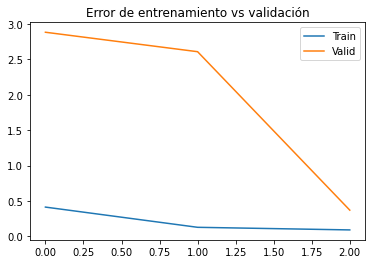

In [ ]:
plt.plot(history_no_pre.history["loss"])
plt.plot(history_no_pre.history["val_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

# Transfer learning

In [ ]:
# Carga de modelo base

efficienNet_base = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                       include_top=False,
                                       input_shape=(150, 150, 3))

efficienNet_base.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (Zero

In [ ]:
## Congelo las capas de la red base

efficienNet_base.trainable = False

In [ ]:
# Agregamos las capas para armar el clasificador que querramos: una capa de 256 neuronas y la salida con 10 unidades.

model = tf.keras.Sequential()

model.add(efficienNet_base)

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),    
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

history = model.fit(train_generator,
                    epochs=3,
                    validation_data=valid_generator)

Epoch 1/3
329/329 [==============================] - 342s 980ms/step - loss: 2.3209 - categorical_accuracy: 0.1011 - val_loss: 2.3161 - val_categorical_accuracy: 0.1000
Epoch 2/3
329/329 [==============================] - 320s 971ms/step - loss: 2.3137 - categorical_accuracy: 0.1061 - val_loss: 2.3212 - val_categorical_accuracy: 0.1000
Epoch 3/3
329/329 [==============================] - 319s 969ms/step - loss: 2.3148 - categorical_accuracy: 0.1018 - val_loss: 2.3098 - val_categorical_accuracy: 0.1000


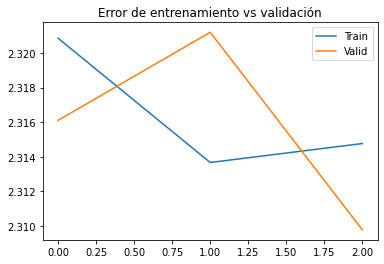

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Error de entrenamiento vs validación")
plt.legend(['Train', 'Valid'])
plt.show()

### Se ve que el error de validación comienza en valores menores cuando se utiliza transfer learning